In [323]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 

# Data Cleaning

In [324]:
data = pd.read_csv("data/car_price.csv")

In [325]:
data.isnull().any()

Unnamed: 0             False
car_name               False
car_prices_in_rupee    False
kms_driven             False
fuel_type              False
transmission           False
ownership              False
manufacture            False
engine                 False
Seats                  False
dtype: bool

In [326]:
data.shape

(5512, 10)

In [327]:
data.head(1)

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats


In [328]:
data.dtypes

Unnamed: 0              int64
car_name               object
car_prices_in_rupee    object
kms_driven             object
fuel_type              object
transmission           object
ownership              object
manufacture             int64
engine                 object
Seats                  object
dtype: object

In [329]:
data.drop(columns = 'Unnamed: 0',inplace=True)

In [330]:
data["engine_vol"] = data.engine.str.replace(" cc","").astype(int)

In [331]:
def convert_to_usd(amount): 
    if 'Lakh' in amount:
        rupees = float(amount.split(' ')[0]) * 100_000
        
    elif 'Crore' in amount:
        rupees = float(amount.split(' ')[0]) * 10_000_000
        
    else:
        rupees = float(amount.replace(',', ''))
    
    usd = rupees * .012 
    return usd


In [332]:
data["car_price_usd"] = data["car_prices_in_rupee"].apply(convert_to_usd)

<Axes: >

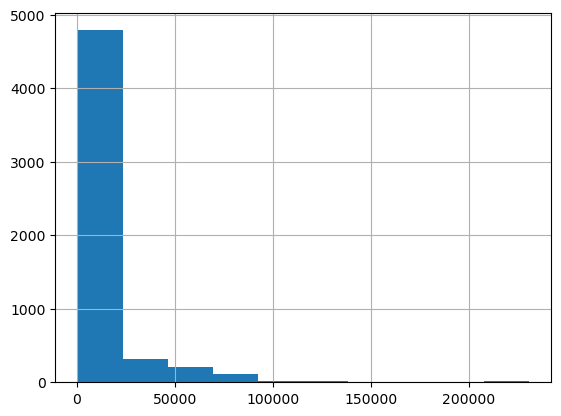

In [333]:
data.car_price_usd.hist()

In [334]:
data["kms_driven"] = data["kms_driven"].str.replace(",","").str.split().str[0].astype(int)

In [335]:
data["car_brand"] = data.car_name.str.split().str[0]

In [336]:
cols_to_drop = ["car_prices_in_rupee", "car_name", "engine"]
cleaned_data = data.drop(columns=cols_to_drop)
cleaned_data.columns = cleaned_data.columns.str.lower()
cleaned_data

,kms_driven,fuel_type,transmission,ownership,manufacture,seats,engine_vol,car_price_usd,car_brand
0,86226,Diesel,Manual,1st Owner,2017,5 Seats,1956,12036.0,Jeep
1,13248,Petrol,Automatic,1st Owner,2021,5 Seats,1330,15396.0,Renault
2,60343,Petrol,Automatic,1st Owner,2016,5 Seats,2494,19680.0,Toyota
3,26696,Petrol,Automatic,1st Owner,2018,5 Seats,1199,9324.0,Honda
4,69414,Petrol,Manual,1st Owner,2016,5 Seats,1199,6180.0,Volkswagen
...,...,...,...,...,...,...,...,...,...
5507,45000,Diesel,Automatic,1st Owner,2018,7 Seats,2995,34680.0,BMW
5508,29000,Petrol,Automatic,2nd Owner,2015,5 Seats,1968,77880.0,BMW
5509,90000,Diesel,Automatic,2nd Owner,2013,5 Seats,2755,16500.0,Jaguar
5510,79000,Diesel,Automatic,3rd Owner,2015,6 Seats,2967,35880.0,BMW


In [337]:
cleaned_data.car_brand.unique()

array(['Jeep', 'Renault', 'Toyota', 'Honda', 'Volkswagen', 'Maruti',
       'Mahindra', 'Hyundai', 'Nissan', 'Kia', 'MG', 'Tata', 'BMW',
       'Mercedes-Benz', 'Datsun', 'Volvo', 'Audi', 'Porsche', 'Ford',
       'Chevrolet', 'Skoda', 'Lexus', 'Land', 'Mini', 'Jaguar',
       'Mitsubishi', 'Force', 'Premier', 'Fiat', 'Maserati', 'Bentley',
       'Isuzu'], dtype=object)

In [338]:
brand_country_map = {'Jeep': 'United States', 'Renault': 'France', 'Toyota': 'Japan','Honda': 'Japan','Volkswagen': 'Germany','Maruti': 'India','Mahindra': 'India','Hyundai': 'South Korea',
    'Nissan': 'Japan', 'Kia': 'South Korea', 'MG': 'United Kingdom', 'Tata': 'India', 'BMW': 'Germany', 'Mercedes-Benz': 'Germany', 
    'Datsun': 'Japan', 'Volvo': 'Sweden', 'Audi': 'Germany', 'Porsche': 'Germany', 
    'Ford': 'United States', 'Chevrolet': 'United States', 'Skoda': 'Czech Republic', 'Lexus': 'Japan', 
    'Land': 'United Kingdom', 'Mini': 'United Kingdom',
    'Jaguar': 'United Kingdom', 'Mitsubishi': 'Japan', 'Force': 'India', 'Premier': 'India', 'Fiat': 'Italy',
    'Maserati': 'Italy', 'Bentley': 'United Kingdom', 'Isuzu': 'Japan'}

In [339]:
cleaned_data["car_country"] = cleaned_data['car_brand'].map(brand_country_map)

In [340]:
cleaned_data["car_country"].unique()

array(['United States', 'France', 'Japan', 'Germany', 'India',
       'South Korea', 'United Kingdom', 'Sweden', 'Czech Republic',
       'Italy'], dtype=object)

In [341]:
country_region_map = {
    'United States': 'North America',
    'France': 'Europe',
    'Japan': 'East Asia',
    'Germany': 'Europe',
    'India': 'South Asia',
    'South Korea': 'East Asia',
    'United Kingdom': 'Europe',
    'Sweden': 'Europe',
    'Czech Republic': 'Europe',
    'Italy': 'Europe' }

In [342]:
cleaned_data["car_region"] = cleaned_data["car_country"].map(country_region_map)

In [343]:
cleaned_data.car_region.unique()

array(['North America', 'Europe', 'East Asia', 'South Asia'], dtype=object)

#  Multicollinearity check

In [344]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + seats + ownership + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                     features
0   427603.320439                    Intercept
1       18.036324          fuel_type[T.Diesel]
2        1.188303        fuel_type[T.Electric]
3        1.367009             fuel_type[T.Lpg]
4       18.033758          fuel_type[T.Petrol]
5       18.364376             seats[T.4 Seats]
6      142.870315             seats[T.5 Seats]
7       13.099909             seats[T.6 Seats]
8      113.003551             seats[T.7 Seats]
9       11.735584             seats[T.8 Seats]
10     173.616622       ownership[T.1st Owner]
11     145.353982       ownership[T.2nd Owner]
12      49.609548       ownership[T.3rd Owner]
13      13.020550       ownership[T.4th Owner]
14       2.750166       ownership[T.5th Owner]
15       1.577881       transmission[T.Manual]
16       1.718414         car_region[T.Europe]
17       1.112072  car_region[T.North America]
18       1.346225     car_region[T.South Asia]
19       1.521569                   kms_driven
20       1.60

`ownership` and `seats` all have high multicollinearity; consider dropping them

In [345]:
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                     features
0   370344.057773                    Intercept
1       17.997305          fuel_type[T.Diesel]
2        1.186357        fuel_type[T.Electric]
3        1.363300             fuel_type[T.Lpg]
4       18.009594          fuel_type[T.Petrol]
5        1.575767       transmission[T.Manual]
6        1.705949         car_region[T.Europe]
7        1.110114  car_region[T.North America]
8        1.344389     car_region[T.South Asia]
9        1.510234                   kms_driven
10       1.398884                  manufacture
11       1.041795                   engine_vol


`fuel type` still has some multicollinearity issue. Lets try combining the features

In [346]:
cleaned_data.fuel_type.unique()

array(['Diesel', 'Petrol', 'Cng', 'Electric', 'Lpg'], dtype=object)

In [347]:
cleaned_data["fuel_type"] = cleaned_data.fuel_type.apply(lambda x: '1' if x =="Electric" else '0')

In [348]:
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

      VIF Factor                     features
0  356291.654631                    Intercept
1       1.012310               fuel_type[T.1]
2       1.569281       transmission[T.Manual]
3       1.633312         car_region[T.Europe]
4       1.094634  car_region[T.North America]
5       1.318861     car_region[T.South Asia]
6       1.315114                   kms_driven
7       1.348468                  manufacture
8       1.038523                   engine_vol


No more multicollinearity after combining features

# Fit initial model 1

In [349]:
cleaned_data

,kms_driven,fuel_type,transmission,ownership,manufacture,seats,engine_vol,car_price_usd,car_brand,car_country,car_region
0,86226,0,Manual,1st Owner,2017,5 Seats,1956,12036.0,Jeep,United States,North America
1,13248,0,Automatic,1st Owner,2021,5 Seats,1330,15396.0,Renault,France,Europe
2,60343,0,Automatic,1st Owner,2016,5 Seats,2494,19680.0,Toyota,Japan,East Asia
3,26696,0,Automatic,1st Owner,2018,5 Seats,1199,9324.0,Honda,Japan,East Asia
4,69414,0,Manual,1st Owner,2016,5 Seats,1199,6180.0,Volkswagen,Germany,Europe
...,...,...,...,...,...,...,...,...,...,...,...
5507,45000,0,Automatic,1st Owner,2018,7 Seats,2995,34680.0,BMW,Germany,Europe
5508,29000,0,Automatic,2nd Owner,2015,5 Seats,1968,77880.0,BMW,Germany,Europe
5509,90000,0,Automatic,2nd Owner,2013,5 Seats,2755,16500.0,Jaguar,United Kingdom,Europe
5510,79000,0,Automatic,3rd Owner,2015,6 Seats,2967,35880.0,BMW,Germany,Europe


In [350]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     432.0
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:28:46   Log-Likelihood:                -61987.
No. Observations:                5512   AIC:                         1.240e+05
Df Residuals:                    5503   BIC:                         1.241e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -2.593e+06   1.49e+05    -17.396      0.000   -2.89e+06    -2.3e+06
fuel_type[T.1]              -1.629e+04   4991.880     -3.264      0.001   -2.61e+04   -6507.073
transmission[T.Manual]      -1.692e+04    695.827    -24.312      0.000   -1.83e+04   -1.56e+04
car_region[T.Europe]         1.363e+04    755.225     18.053      0.000    1.22e+04    1.51e+04
car_region[T.North America]   782.4313   1153.530      0.678      0.498   -1478.943    3043.806
car_region[T.South Asia]    -1201.4137    598.098     -2.009      0.045   -2373.922     -28.906
kms_driven                     -0.0207      0.007     -3.027      0.002      -0.034      -0.007
manufacture                  1297.1127     73.834     17.568      0.000    1152.369    1441.856
engine_vol                      2.2721      0.439      5.171      0.000       1.411       3.134
==============================================================================
Omnibus:                     5889.305   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491914.073
Skew:                           5.355   Prob(JB):                         0.00
Kurtosis:                      48.024   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential Points

In [351]:
infl = model.get_influence()

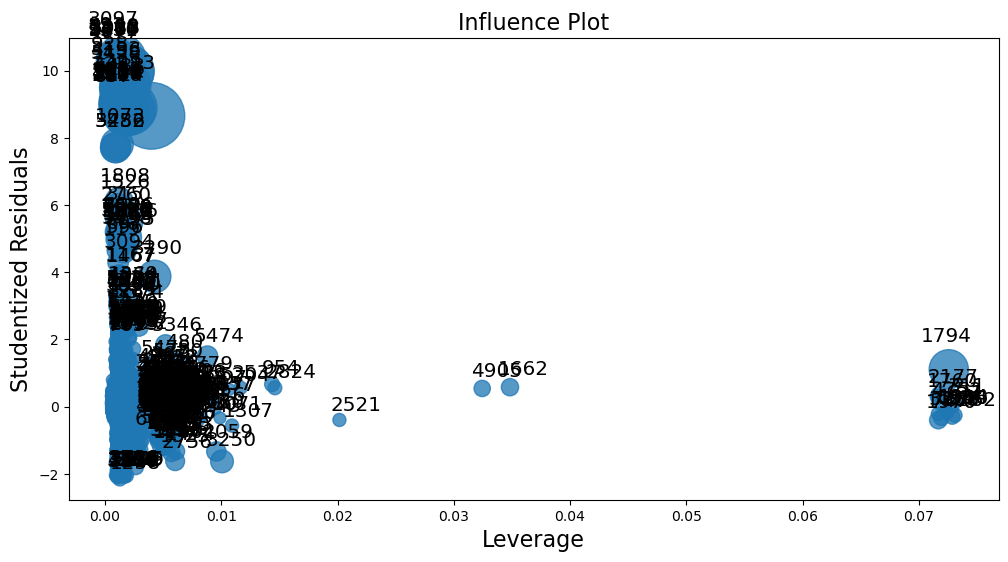

In [352]:
fig, ax = plt.subplots(figsize=(12,6))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [353]:
import scipy
n=5512
p=9
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(cleaned_data.index[atyp_stud],reg_studs[atyp_stud])

Index([ 119,  205,  227,  283,  315,  370,  596,  607,  632,  697,
       ...
       5370, 5374, 5406, 5422, 5438, 5458, 5470, 5482, 5483, 5508],
      dtype='int64', length=130) [ 4.65664403  2.04279537  2.15954949  2.29210903  5.50145304  2.377561
  4.64706822  2.09361637  2.58708766  4.74189941  1.98080382  2.29156244
  2.31294654  2.24444313  8.74119277  5.28700009 -2.04111984  2.94017808
 10.30077261  2.103491    9.56605657  8.8842174   7.80316963  9.04276302
  2.54190311  3.92192252  2.35295535  2.27594711  2.3645642   3.20539326
  2.20819799 -2.14648059  8.88995414  5.14511154  2.96819948  2.44189681
  1.99682249 10.20304638  2.22409371  3.39186209  2.48027612  3.90380284
  2.41469285 10.16269784  2.30248599  5.04493903  2.42008766  5.94953149
  3.19907423  2.21977412  8.88346119 -1.97252452  2.0629314   6.11007501
  2.47518831  2.07365861 -2.01246403 -2.05816714 -2.03139428  2.33271168
 -2.01746534  5.61486533  2.06751323  8.89460192  8.9687859   3.27208451
  2.34261797  9.9777

In [354]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(cleaned_data.index[atyp_cook],reg_cook[atyp_cook])

Index([ 119,  283,  288,  315,  370,  480,  596,  632,  697,  747,
       ...
       5370, 5374, 5406, 5422, 5438, 5458, 5470, 5474, 5482, 5483],
      dtype='int64', length=119) 119     0.002673
283     0.001086
288     0.000790
315     0.006406
370     0.001830
          ...   
5458    0.015222
5470    0.000803
5474    0.002229
5482    0.005976
5483    0.019456
Name: cooks_d, Length: 119, dtype: float64


In [355]:
infl_points = cleaned_data.index[atyp_cook & atyp_stud]

## Heteroscedasticity

In [356]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 290.17164387630635, 'LM-Test p-value': 5.078815186397392e-58}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

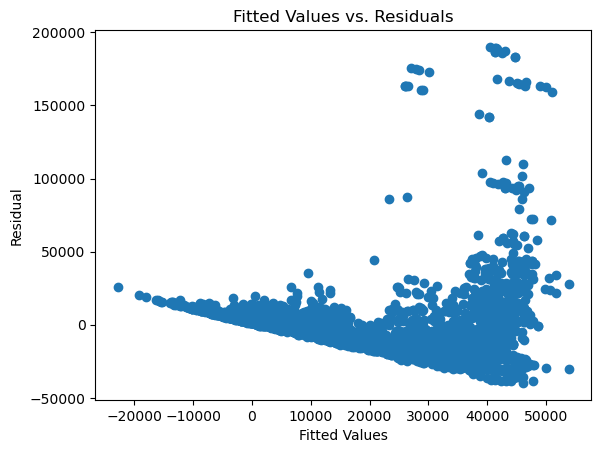

In [357]:
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

In [358]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     432.0
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:29:11   Log-Likelihood:                -61987.
No. Observations:                5512   AIC:                         1.240e+05
Df Residuals:                    5503   BIC:                         1.241e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -2.593e+06   1.49e+05    -17.396      0.000   -2.89e+06    -2.3e+06
fuel_type[T.1]              -1.629e+04   4991.880     -3.264      0.001   -2.61e+04   -6507.073
transmission[T.Manual]      -1.692e+04    695.827    -24.312      0.000   -1.83e+04   -1.56e+04
car_region[T.Europe]         1.363e+04    755.225     18.053      0.000    1.22e+04    1.51e+04
car_region[T.North America]   782.4313   1153.530      0.678      0.498   -1478.943    3043.806
car_region[T.South Asia]    -1201.4137    598.098     -2.009      0.045   -2373.922     -28.906
kms_driven                     -0.0207      0.007     -3.027      0.002      -0.034      -0.007
manufacture                  1297.1127     73.834     17.568      0.000    1152.369    1441.856
engine_vol                      2.2721      0.439      5.171      0.000       1.411       3.134
==============================================================================
Omnibus:                     5889.305   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491914.073
Skew:                           5.355   Prob(JB):                         0.00
Kurtosis:                      48.024   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

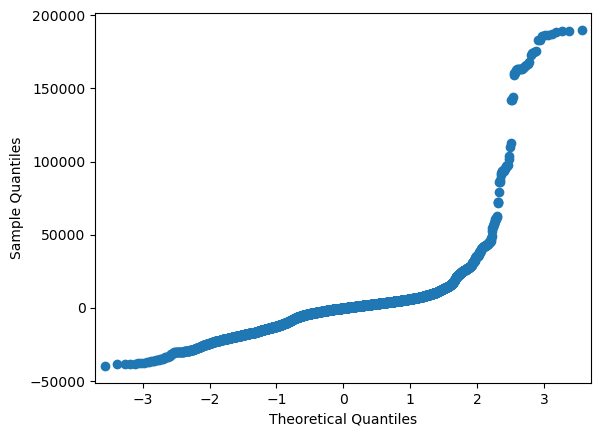

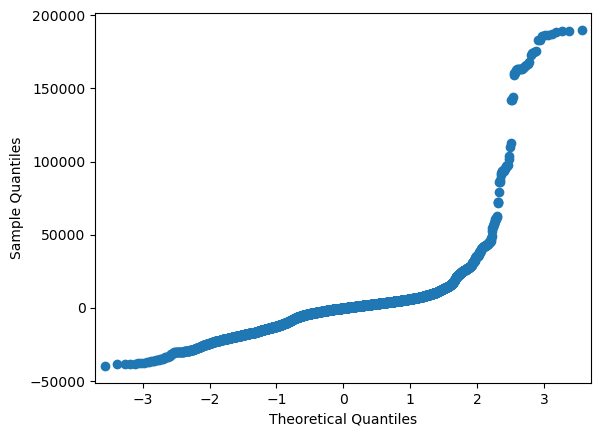

In [359]:
sm.qqplot(model.resid)

All assumptions violated. Next step is to refit the model after 

* Removing influential points 
* Log transform y

# Fit model 2

In [360]:
cleaned_data_v2 = cleaned_data.drop(infl_points)

In [361]:
cleaned_data_v2["kms_driven"] = np.log(cleaned_data_v2["kms_driven"])

In [396]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     813.0
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:59:50   Log-Likelihood:                -57603.
No. Observations:                5417   AIC:                         1.152e+05
Df Residuals:                    5408   BIC:                         1.153e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.967e+06    8.6e+04    -22.858      0.000   -2.14e+06    -1.8e+06
fuel_type[T.1]              -9977.0964   2707.497     -3.685      0.000   -1.53e+04   -4669.311
transmission[T.Manual]      -1.265e+04    380.032    -33.299      0.000   -1.34e+04   -1.19e+04
car_region[T.Europe]         1.086e+04    415.020     26.164      0.000       1e+04    1.17e+04
car_region[T.North America]  1323.6132    625.978      2.114      0.035      96.445    2550.782
car_region[T.South Asia]     -730.4183    324.599     -2.250      0.024   -1366.764     -94.073
kms_driven                  -1087.7923    206.912     -5.257      0.000   -1493.424    -682.161
manufacture                   989.7560     42.090     23.515      0.000     907.242    1072.270
engine_vol                      1.6608      0.242      6.862      0.000       1.186       2.135
==============================================================================
Omnibus:                     1710.274   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8549.839
Skew:                           1.436   Prob(JB):                         0.00
Kurtosis:                       8.443   Cond. No.                     1.61e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential points

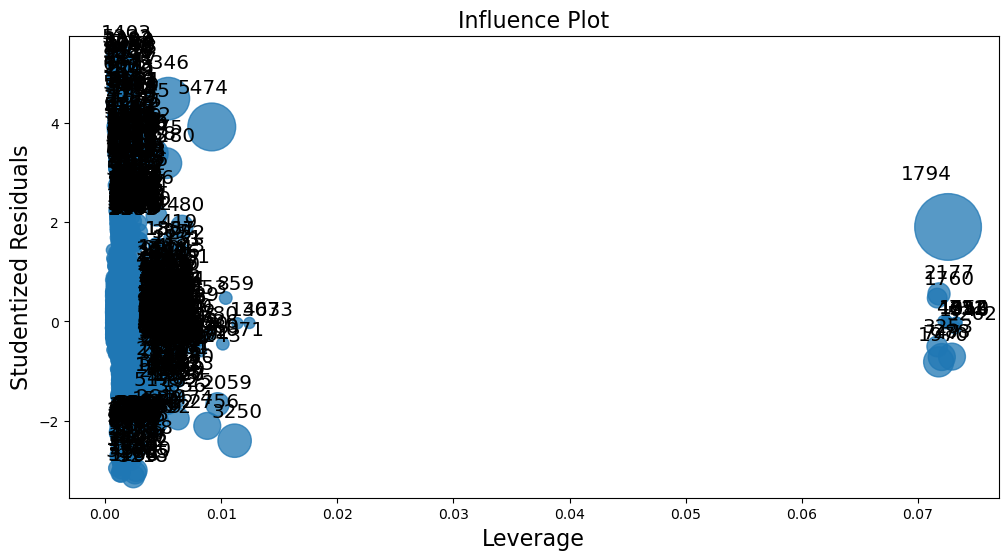

In [364]:
infl = model.get_influence()
fig, ax = plt.subplots(figsize=(12,6))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [365]:
import scipy
n=5417
p=9
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(cleaned_data_v2.index[atyp_stud],reg_studs[atyp_stud])

Index([   1,    5,    6,    9,   45,   64,   96,  107,  144,  145,
       ...
       5475, 5476, 5478, 5479, 5481, 5490, 5493, 5497, 5504, 5508],
      dtype='int64', length=335) [-2.08240472 -2.14045129 -2.16400654 -2.25424799 -2.37680546  2.13222947
  2.8190061  -2.14546443 -2.22679042 -2.05360587  3.05494024  4.68687805
 -2.08391869 -2.08116366  4.82765824  2.50488029  2.07946222  2.99307459
  3.72392483 -2.02571667 -2.07711283  2.53186413  3.6253556   3.35725478
 -1.98330781  2.65737195 -2.0406749   2.35099873  3.49159886 -2.25195427
  4.40286729  2.37129033  2.76825215 -2.26274467  4.75395321  2.11178599
  1.98679396  2.59355206 -2.16673773 -2.22550769 -1.96758055 -2.45351306
  4.23330447  2.89240513  4.40512175  3.19606919  3.57886963  5.09487684
  2.41946787  2.03617808  3.40041649  3.65079349 -1.98396751  5.02719833
  3.54723845  2.75192457  2.30688953  3.92957083  2.41535025  3.42077757
  4.36681135  3.38321412  4.62013272  3.9769108   4.40889697  3.05622648
  2.34447446 -2.01

In [366]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(cleaned_data_v2.index[atyp_cook],reg_cook[atyp_cook])

Index([  45,   64,   96,  100,  157,  164,  205,  227,  252,  277,
       ...
       5475, 5476, 5478, 5479, 5481, 5490, 5493, 5497, 5504, 5508],
      dtype='int64', length=328) 45      0.000809
64      0.002245
96      0.002131
100     0.000763
157     0.000801
          ...   
5490    0.001340
5493    0.000860
5497    0.001435
5504    0.001051
5508    0.002756
Name: cooks_d, Length: 328, dtype: float64


In [367]:
infl_points = cleaned_data_v2.index[atyp_cook & atyp_stud]

In [368]:
cleaned_data_v3 = cleaned_data_v2.drop(infl_points)

In [369]:
model_after = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v3).fit()
model_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     888.7
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:29:49   Log-Likelihood:                -52634.
No. Observations:                5159   AIC:                         1.053e+05
Df Residuals:                    5150   BIC:                         1.053e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.612e+06   5.66e+04    -28.471      0.000   -1.72e+06    -1.5e+06
fuel_type[T.1]              -5495.0032   1760.312     -3.122      0.002   -8945.962   -2044.044
transmission[T.Manual]       -1.02e+04    252.330    -40.417      0.000   -1.07e+04   -9703.885
car_region[T.Europe]         7210.0425    280.861     25.671      0.000    6659.435    7760.650
car_region[T.North America]  1274.8680    407.034      3.132      0.002     476.909    2072.827
car_region[T.South Asia]     -640.0132    211.666     -3.024      0.003   -1054.969    -225.058
kms_driven                   -419.1732    139.865     -2.997      0.003    -693.369    -144.978
manufacture                   809.2311     27.697     29.217      0.000     754.933     863.529
engine_vol                      1.3924      0.164      8.466      0.000       1.070       1.715
==============================================================================
Omnibus:                     1347.043   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5199.072
Skew:                           1.251   Prob(JB):                         0.00
Kurtosis:                       7.234   Cond. No.                     1.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heteroscedasticity

In [370]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 1650.784457328582, 'LM-Test p-value': 0.0}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

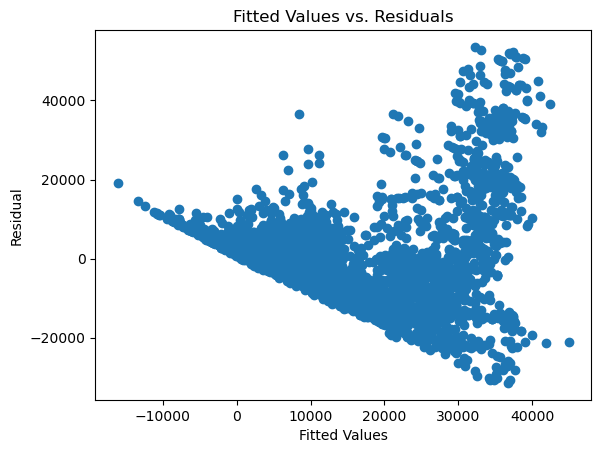

In [371]:
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

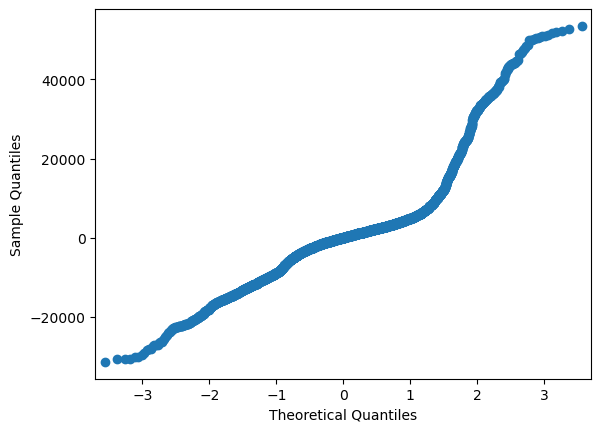

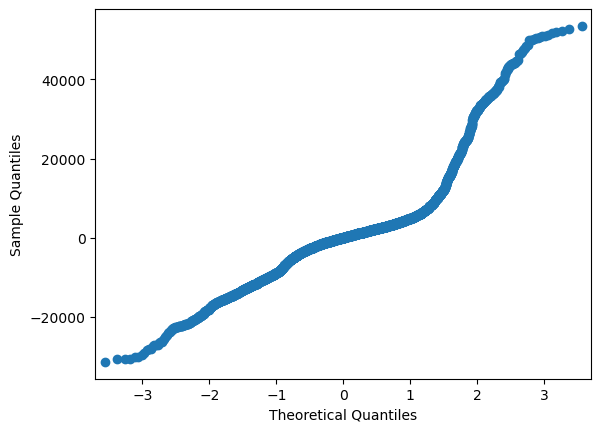

In [372]:
sm.qqplot(model.resid)

# Fitting models by region

# North America

In [377]:
NA_cars = cleaned_data_v2.query("car_region=='North America'")

In [378]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                NA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     146.3
Date:                Sat, 07 Oct 2023   Prob (F-statistic):           1.12e-68
Time:                        22:42:32   Log-Likelihood:                -2958.4
No. Observations:                 299   AIC:                             5927.
Df Residuals:                     294   BIC:                             5945.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -2.19e+06    1.7e+05    -12.851      0.000   -2.53e+06   -1.85e+06
transmission[T.Manual] -1.135e+04    860.113    -13.193      0.000    -1.3e+04   -9654.813
kms_driven              -427.7301    514.931     -0.831      0.407   -1441.149     585.689
manufacture             1097.5681     83.335     13.171      0.000     933.560    1261.576
engine_vol                 0.8891      0.486      1.829      0.068      -0.068       1.846
==============================================================================
Omnibus:                       31.015   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.511
Skew:                           0.488   Prob(JB):                     4.01e-17
Kurtosis:                       5.260   Cond. No.                     1.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heteroscedasticity

{'LM Statistic': 121.03739206118617, 'LM-Test p-value': 3.2067963704897997e-25}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

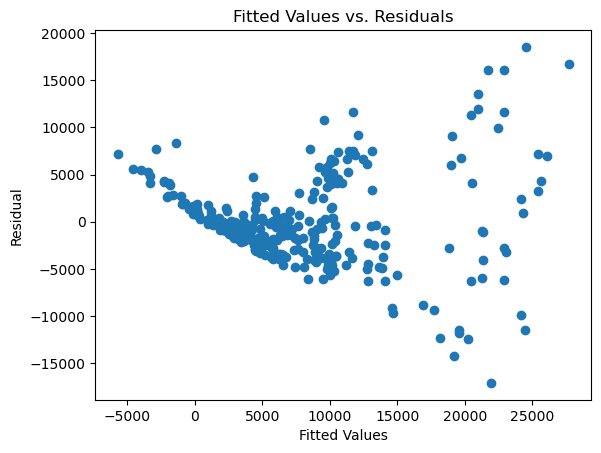

In [388]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

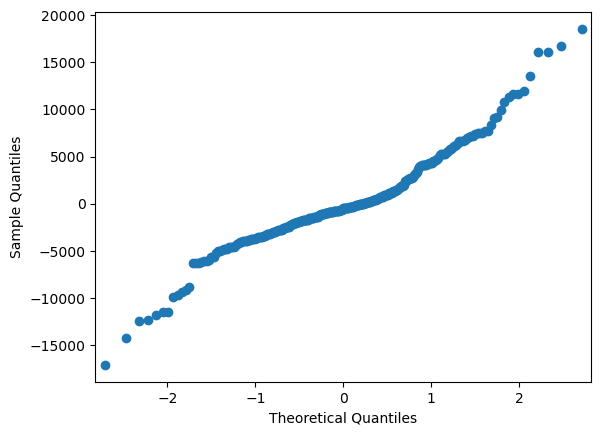

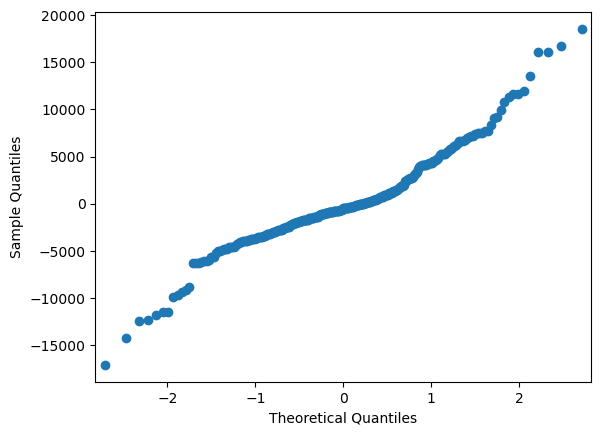

In [392]:
sm.qqplot(model.resid)

# Europe

In [393]:
EU_cars = cleaned_data_v2.query("car_region=='Europe'")

In [394]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                EU_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     270.3
Date:                Sat, 07 Oct 2023   Prob (F-statistic):          1.99e-193
Time:                        22:56:03   Log-Likelihood:                -13333.
No. Observations:                1201   AIC:                         2.668e+04
Df Residuals:                    1195   BIC:                         2.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.409e+06   3.82e+05    -14.156      0.000   -6.16e+06   -4.66e+06
fuel_type[T.1]          -2.14e+04   8089.795     -2.646      0.008   -3.73e+04   -5530.941
transmission[T.Manual] -2.405e+04   1066.358    -22.552      0.000   -2.61e+04    -2.2e+04
kms_driven             -2226.2619    769.531     -2.893      0.004   -3736.044    -716.479
manufacture             2708.8899    186.710     14.509      0.000    2342.573    3075.207
engine_vol                 2.8582      0.734      3.894      0.000       1.418       4.298
==============================================================================
Omnibus:                        8.272   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.358
Skew:                           0.175   Prob(JB):                       0.0153
Kurtosis:                       3.212   Cond. No.                     2.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 1650.784457328582, 'LM-Test p-value': 0.0}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

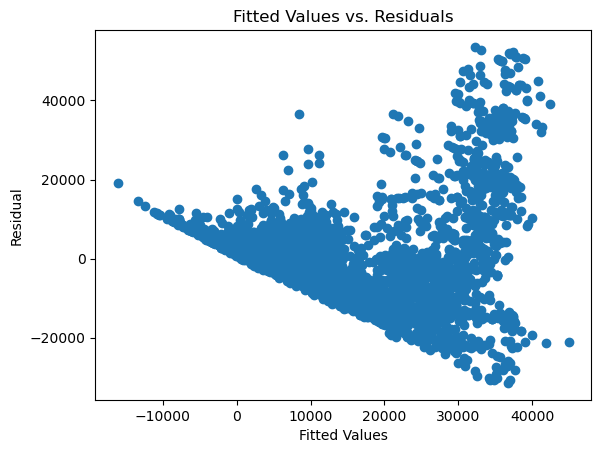

In [397]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

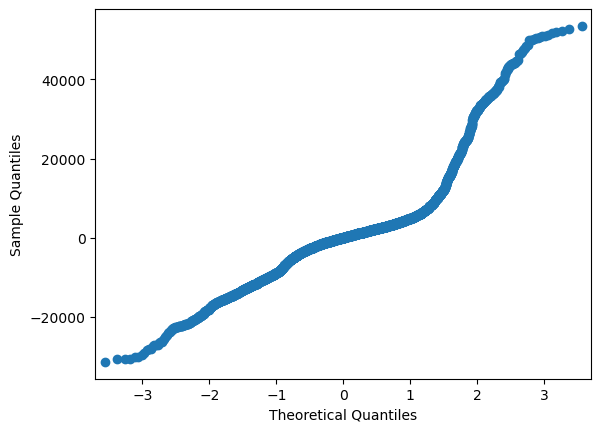

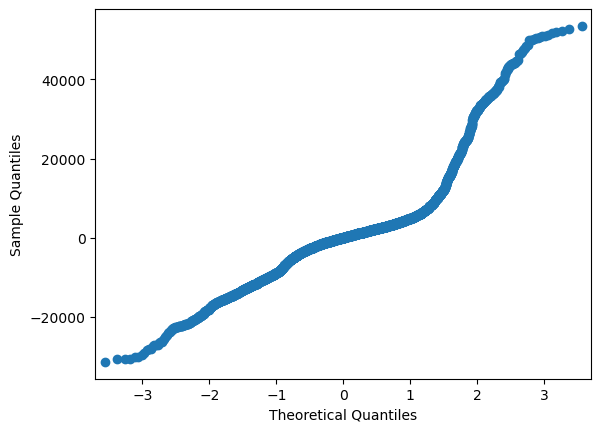

In [398]:
sm.qqplot(model.resid)

# East Asia

In [401]:
EA_cars = cleaned_data_v2.query("car_region=='East Asia'")

In [402]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                EA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     303.5
Date:                Sat, 07 Oct 2023   Prob (F-statistic):          3.40e-240
Time:                        23:01:22   Log-Likelihood:                -19552.
No. Observations:                1942   AIC:                         3.912e+04
Df Residuals:                    1936   BIC:                         3.915e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.895e+06   8.37e+04    -22.656      0.000   -2.06e+06   -1.73e+06
fuel_type[T.1]          1.297e+04   5723.486      2.267      0.024    1749.696    2.42e+04
transmission[T.Manual] -7446.4230    334.758    -22.244      0.000   -8102.947   -6789.898
kms_driven               716.5184    198.994      3.601      0.000     326.253    1106.784
manufacture              943.0459     40.916     23.048      0.000     862.802    1023.290
engine_vol                 1.0496      0.247      4.245      0.000       0.565       1.535
==============================================================================
Omnibus:                     1242.688   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17164.253
Skew:                           2.819   Prob(JB):                         0.00
Kurtosis:                      16.429   Cond. No.                     1.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 213.51664471686396, 'LM-Test p-value': 3.634994158703908e-44}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

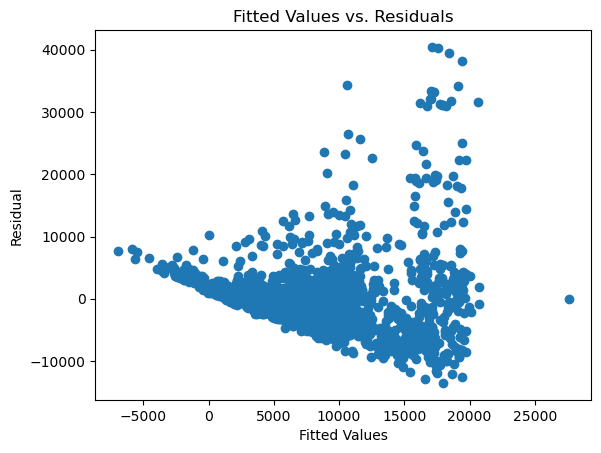

In [403]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
p = model.fittedvalues

res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

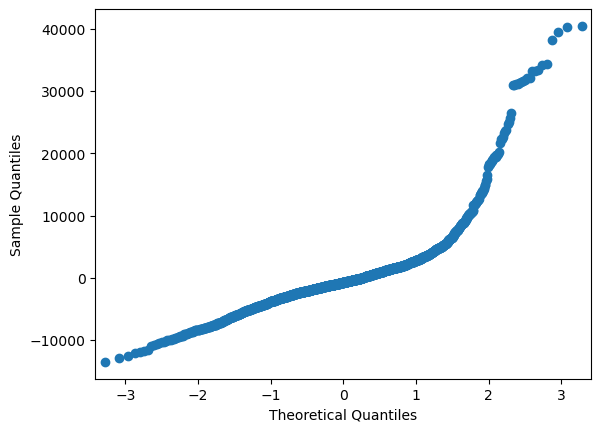

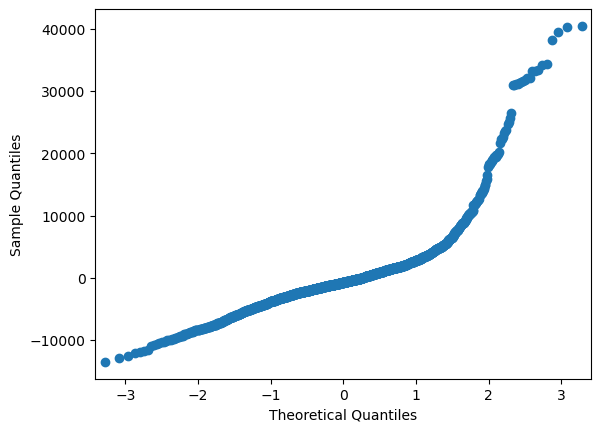

In [404]:
sm.qqplot(model.resid)

# South Asia 

In [405]:
SA_cars = cleaned_data_v2.query("car_region=='South Asia'")

In [406]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                SA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     342.0
Date:                Sat, 07 Oct 2023   Prob (F-statistic):          3.71e-264
Time:                        23:04:12   Log-Likelihood:                -18723.
No. Observations:                1975   AIC:                         3.746e+04
Df Residuals:                    1969   BIC:                         3.749e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.244e+06   3.99e+04    -31.174      0.000   -1.32e+06   -1.17e+06
fuel_type[T.1]          -915.2949   1088.167     -0.841      0.400   -3049.374    1218.784
transmission[T.Manual] -2935.0664    266.972    -10.994      0.000   -3458.644   -2411.488
kms_driven               -78.7824    103.871     -0.758      0.448    -282.491     124.926
manufacture              621.7650     19.536     31.826      0.000     583.451     660.079
engine_vol                 0.5327      0.129      4.124      0.000       0.279       0.786
==============================================================================
Omnibus:                      630.568   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2380.070
Skew:                           1.533   Prob(JB):                         0.00
Kurtosis:                       7.418   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 256.0788720269225, 'LM-Test p-value': 2.726695953446313e-53}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

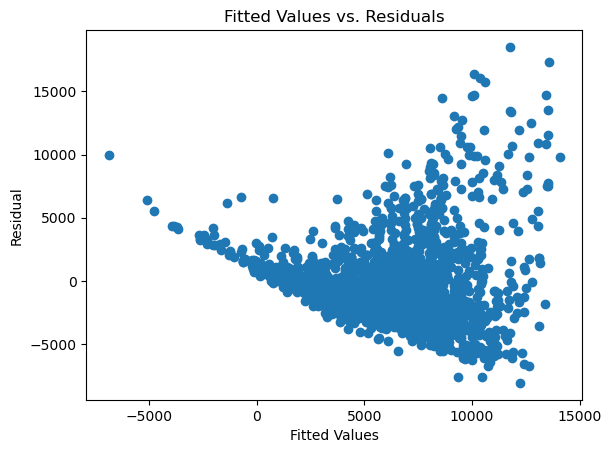

In [407]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
p = model.fittedvalues

res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

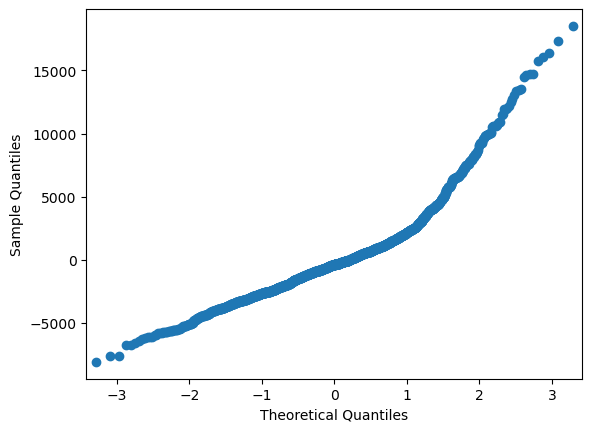

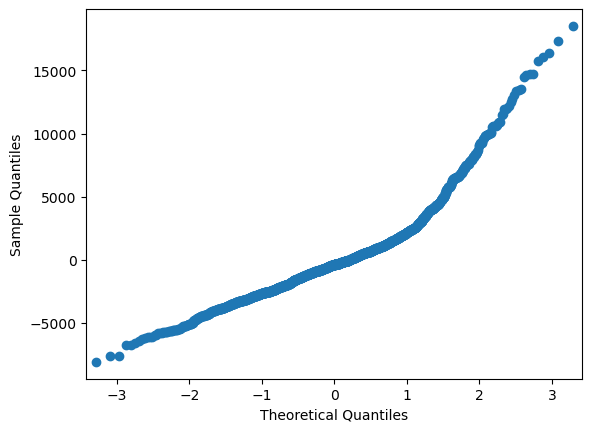

In [408]:
sm.qqplot(model.resid)

# HC3 robust standard error

https://timeseriesreasoning.com/contents/a-tutorial-on-whites-heteroskedasticity-consistent-estimator-using-python-and-statsmodels/

In [415]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v2).fit(cov_type="HC3")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     320.8
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:26:46   Log-Likelihood:                -57603.
No. Observations:                5417   AIC:                         1.152e+05
Df Residuals:                    5408   BIC:                         1.153e+05
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.967e+06   7.12e+04    -27.605      0.000   -2.11e+06   -1.83e+06
fuel_type[T.1]              -9977.0964   1903.719     -5.241      0.000   -1.37e+04   -6245.877
transmission[T.Manual]      -1.265e+04    437.364    -28.934      0.000   -1.35e+04   -1.18e+04
car_region[T.Europe]         1.086e+04    543.902     19.964      0.000    9792.374    1.19e+04
car_region[T.North America]  1323.6132    320.017      4.136      0.000     696.391    1950.835
car_region[T.South Asia]     -730.4183    185.078     -3.947      0.000   -1093.164    -367.673
kms_driven                  -1087.7923    228.875     -4.753      0.000   -1536.379    -639.205
manufacture                   989.7560     34.894     28.365      0.000     921.366    1058.146
engine_vol                      1.6608      0.284      5.839      0.000       1.103       2.218
==============================================================================
Omnibus:                     1710.274   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8549.839
Skew:                           1.436   Prob(JB):                         0.00
Kurtosis:                       8.443   Cond. No.                     1.61e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.61e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""